# Linearization Deep Dive

Usefull to inspect the linearization signals for a given shotfile

In [4]:
# %matplotlib inline

import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from rpspy.linearization import _linearization
from rpspy.read_rtr_data import get_timestamps, get_markers, get_default_shotfile_dir, get_sampling_frequency

# Parameters

In [5]:
shot = 36372
# shotfile_dir = f"/afs/ipp-garching.mpg.de/home/a/augd/rawfiles/RTR/{shot//10}/{shot}/"
# shotfile_dir = f"/afs/ipp-garching.mpg.de/home/d/danielhfc/shotfiles/{shot}/"
shotfile_dir = get_default_shotfile_dir(shot)
sampling_frequency = get_sampling_frequency(shot, shotfile_dir)

In [6]:
time = get_timestamps(shot, shotfile_dir=shotfile_dir)

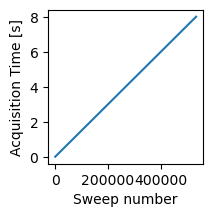

In [7]:
plt.figure(figsize=(2, 2))
plt.plot(time)
plt.xlabel("Sweep number")
plt.ylabel("Acquisition Time [s]");

In [8]:
markers = get_markers(shot, shotfile_dir=shotfile_dir)

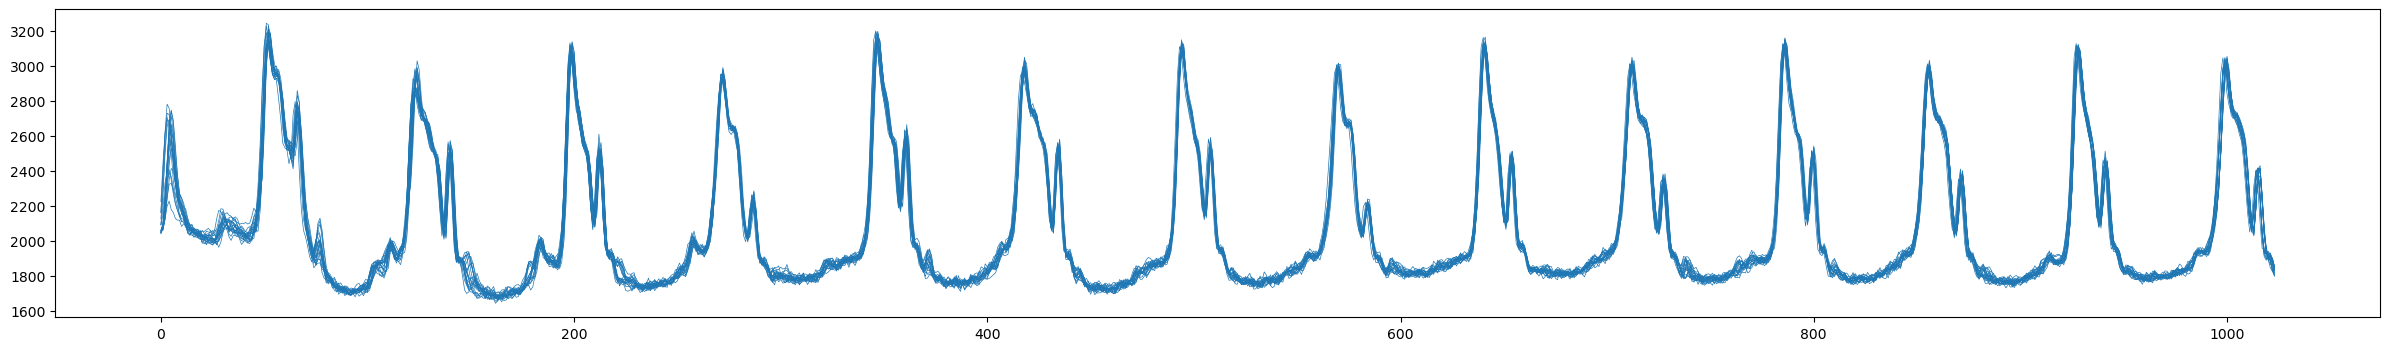

In [9]:
plt.figure(figsize=(30, 4))
plt.plot(np.arange(1024), markers[1:100:5].T, color='C0', alpha=1, lw=0.5);

**Testing the core linearization function**

In the middle of this cell, put the core of the `get_frequency_time_curve` function.

In [10]:
time_instant = 0.5

# Plot the markers, and the integral of the beat frequency
sweep = np.rint(time_instant / 35e-6).astype(np.int)

# Create a time vector with the time samples in seconds
time = np.arange(1024)/sampling_frequency

with open(f"{shotfile_dir}RTR_{shot}_Markers.sig", "rb") as markers_file:
    with open(f"{shotfile_dir}RTR_{shot}_Freq_Cal.sig", "rb") as calibration_file:

        markers_file.seek(sweep * 2048)
        calibration_file.seek(sweep * 2048)
            
        for i in range(4):
            band = bands[i % len(bands)]
            
            # Read the calibration data
            content = calibration_file.read(2048)
            calibration = iter_unpack("H", content)
            calibration = np.array([s[0] for s in calibration], dtype=np.int)
            
            # Read the markers file
            content = markers_file.read(2048)
            markers = iter_unpack("H", content)
            markers = np.array([s[0] for s in markers], dtype=np.int)
            
            # Coarse spectrogram of the calibration data to determine average beat frequency
            y, x, z = spectrogram(calibration, fs=sampling_frequency, nperseg=128, noverlap=64, nfft=128)
            frequency = y[np.argmax(z, axis=0)]
            
            # Identify band and choose the apropriate marker spacing and fft window
            if np.average(frequency) > 0.29e7:
                distance = 25
                nperseg = 25
            else:
                distance = 40
                nperseg = 40
                
            
            # CORE LINEARIZATION FUNCTION ---------------------------------------------------------------------------
            
            
            (markers_signal, markers_values, calibration_signal, sampling_frequency, delay_line, spectrogram_kw, find_peaks_kw) = (
                markers, band.markers, calibration, sampling_frequency, 
#                 14.1643e-9,
                14.08e-9,
                {"nperseg": nperseg, "noverlap": nperseg-1, "nfft": 2048, "window": "hamming"},
                {"prominence": 100, "distance": distance}
            )
            
            # ------------------------------------------------------------------------------------------------------
            # ------------------------------------------------------------------------------------------------------
            
            # Define the time axis of acquisition (used in intermediate calculations)
            time = np.arange(len(markers_signal)) / sampling_frequency

            # Spectrogram of the calibration signal & beat frequency
            y, x, z = spectrogram(calibration_signal, fs=sampling_frequency, **spectrogram_kw)
            beat_frequency = y[np.argmax(z, axis=0)]

            # Resample the beat frequency on the time axis, artificially extending the sides (using a constant value)
            beat_frequency = interp1d(x, beat_frequency, kind='cubic', bounds_error=False, 
                                      fill_value=(beat_frequency[0], beat_frequency[-1]))(time)       

            # Calculate the cumulative integral to obtain the relative frequency-time curve
            cum = cumulative_trapezoid(beat_frequency, time) / delay_line
            cum = np.insert(cum, 0, 0.0)  # Manually add a zero to the begining

            # Find the peaks corresponding to the markers
            peaks, properties = find_peaks(markers_signal, **find_peaks_kw)

            # Find the absolute frequency-time curve by least-squares fitting
            error = time[1] * np.take(beat_frequency, peaks) / delay_line  # Error is (sampling period) x (frequency rate)
            offset = - np.sum((np.take(cum, peaks) - markers_values[:len(peaks)]) / error**2) / np.sum(1/error**2)

            frequency = cum + offset
            
#             return frequency
        
            # ------------------------------------------------------------------------------------------------------
            # ------------------------------------------------------------------------------------------------------
            
                        
            # Linearize the calibration signal
            frequency_linear = np.linspace(frequency[0], frequency[-1], 1024)
            calibration_linear = griddata(frequency, calibration, frequency_linear)
            
            # Spectrogram of the linearized calibration curve
            _, _, z_linear = spectrogram(calibration_linear, fs=sampling_frequency, **spectrogram_kw)
            beat_frequency_linear = y[np.argmax(z_linear, axis=0)]
            
            # Resample the beat frequency to artificially extend the sides
            beat_frequency_linear = griddata(x, beat_frequency_linear, time, method='nearest')
            
            # Compute full FFT of the linearized vs. unlinearized calibration signals
            spectrum = (rfftfreq(len(calibration), time[1]), np.abs(rfft(detrend(calibration))))
            spectrum_linear = (rfftfreq(len(calibration), time[1]), np.abs(rfft(detrend(calibration_linear))))
            
            # -------------------------------------------------------------------------------------------------------
            # Plotting
            # -------------------------------------------------------------------------------------------------------
            fig = plt.figure(figsize=(30, 4))
            axes = []
            axes.append(plt.subplot(3, 4, 1))                    # 0: Markers
            axes.append(plt.subplot(3, 4, 5, sharex=axes[-1]))   # 1: freq-time
            axes.append(plt.subplot(3, 4, 9, sharex=axes[-1]))   # 2: freq-time detrended
            axes.append(plt.subplot(2, 4, 2))                    # 3: Calibration signal
            axes.append(plt.subplot(2, 4, 6, sharex=axes[-1]))   # 4: Linearized calibration signal
            axes.append(plt.subplot(2, 4, 3))                    # 5: SFFT of calibration signal
            axes.append(plt.subplot(2, 4, 7, sharex=axes[-1]))   # 6: SFFT of calibration signal linearized
            axes.append(plt.subplot(1, 4, 4))                    # 7: FFT of calibration signal & linearized c.s.
#             fig, axes = plt.subplots(1, 6, figsize=(30, 3))       

            axes[0].plot(time * 1e6, markers)
            axes[0].scatter(
                np.take(time, peaks) * 1e6, np.take(markers, peaks), color='C1', zorder=3,
                label=f"{len(peaks)} markers out of {band.expected_markers.size}")
            axes[0].set_ylabel(f"{band.name}-Band".replace("BandName.", ""))
            axes[0].legend(loc='lower left')
            
            axes[1].plot(time * 1e6, 1e-9 * (cum + offset))
            axes[1].scatter(np.take(time, peaks) * 1e6, 1e-9 * band.markers[:len(peaks)], color='C1')
            axes[1].set_ylabel("F [GHz]")
            axes[1].grid()
        
            axes[2].plot(time * 1e6, 1e-6 * (frequency - frequency_linear))
            axes[2].errorbar(np.take(time, peaks) * 1e6, 1e-6 * (band.markers[:len(peaks)] - np.take(frequency_linear, peaks)), color='C1', yerr=1e-6*time[1]*np.take(beat_frequency, peaks)/14.1643e-9, ls='')
            axes[2].set_xlabel("Time [us]")
            axes[2].set_ylabel("$\Delta$F [MHz]")
            axes[2].grid()
            
            axes[3].plot(time*1e6, calibration, lw=0.6)
            axes[4].plot(time*1e6, calibration_linear, lw=0.6)
            axes[4].set_xlabel("Time [us]")
        
            axes[5].pcolormesh(x*1e6, y*1e-6, z, shading='nearest')
            axes[5].plot(time*1e6, beat_frequency*1e-6, color='red')
            axes[5].set_ylabel("F [MHz]")
            axes[5].set_ylim(0, 8)
            axes[5].annotate(f"$\Delta$f = {band.multiplier * (frequency[-1] - frequency[0]) * 1e-9:.2f} GHz\n" +
            f"Expected: {np.diff(band.probing_limits)[0] * 1e-9:.2f} GHz", xy=(5, 6), color='w')        
        
        
            axes[6].pcolormesh(x*1e6, y*1e-6, z_linear, shading='nearest')
            axes[6].plot(time * 1e6, beat_frequency_linear * 1e-6, color='red')
            axes[6].set_xlabel("Time [us]")
            axes[6].set_ylabel("F [MHz]")
            axes[6].set_ylim(0, 8)
            
            axes[7].plot(spectrum[0] * 1e-6, spectrum[1])
            axes[7].plot(spectrum_linear[0] * 1e-6, spectrum_linear[1])
            axes[7].set_xlim(1, 5)
            axes[7].set_xlabel("F [MHz]")

            plt.subplots_adjust(hspace=0.1)

/tmp/ipykernel_81197/1150502131.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sweep = np.rint(time_instant / 35e-6).astype(np.int)


NameError: name 'bands' is not defined

In [94]:
def _linearization(markers_signal, markers_values, calibration_signal, sampling_frequency, delay_line, spectrogram_kw, find_peaks_kw, debug):
    """
    Core linearization function. Can be used for debugging purposes.
    
    Parameters
    ----------
        markers_signal: ndarray
            1D array of the markers signal.
            
        markers_values: ndarray
            1D array of the frequency values associated with each marker in Hz. 
            The number of elements on this array should be at least as big than the number of peaks in `markers_signal`.
            The last values are discarded if there are more elements than peaks in `markers_signal`.
            
        calibration_signal: ndarray
            1D array with the calibration signal.
            
        sampling_frequency: float
            Sampling frequency of the acquisition system.
            
        delay_line: float
            Time delay in seconds of the delay line used to produce the calibration signal. 
            
        spectrogram_kw: dictionary
            Dictionary of aditional keyword arguments passed to scipy.signal.spectrogram besides the sampling frequency.
            
        find_peaks_kw: dictionary
            Dictionary of keyword arguments passed to scipy.signal.find_peaks.
            
        debug: bool
            If True, returns all intermediate computations.
            
    Returns
    -------
        frequency: ndarray
            1D array of the absolute frequency in Hz that the system is at for each acquisition sample.
    """

    # Define the time axis of acquisition (used in intermediate calculations)
    time = np.arange(len(markers_signal)) / sampling_frequency

    # Spectrogram of the calibration signal & beat frequency
    y, x, z = spectrogram(calibration_signal, fs=sampling_frequency, **spectrogram_kw)
    beat_frequency = y[np.argmax(z, axis=0)]

    # Resample the beat frequency on the time axis, artificially extending the sides (using a constant value)
    beat_frequency = interp1d(x, beat_frequency, kind='cubic', bounds_error=False, 
                              fill_value=(beat_frequency[0], beat_frequency[-1]))(time)       

    # Calculate the cumulative integral to obtain the relative frequency-time curve
    cum = cumulative_trapezoid(beat_frequency, time) / delay_line
    cum = np.insert(cum, 0, 0.0)  # Manually add a zero to the begining

    # Find the peaks corresponding to the markers
    peaks, properties = find_peaks(markers_signal, **find_peaks_kw)

    # Find the absolute frequency-time curve by least-squares fitting
    error = time[1] * np.take(beat_frequency, peaks) / delay_line  # Error is (sampling period) x (frequency rate)
    offset = - np.sum((np.take(cum, peaks) - markers_values[:len(peaks)]) / error**2) / np.sum(1/error**2)

    frequency = cum + offset

    if not debug:
        return frequency
    else:
        return frequency, time, x, y, z, beat_frequency, cum, peaks


def get_frequency_time_curve(markers_signal, markers_values, calibration_signal, sampling_frequency, delay_line, spectrogram_kw, find_peaks_kw):
    """
    Get the frequency versus time characteristic of a given band.
    This routine uses scipy.signal.find_peaks to identify the markers and a spectrogram to determine the instantaneous sweep rate of the oscilator.
    
    Parameters
    ----------
        markers_signal: ndarray
            1D array of the markers signal.
            
        markers_values: ndarray
            1D array of the frequency values associated with each marker in Hz. 
            The number of elements on this array should be at least as big than the number of peaks in `markers_signal`.
            The last values are discarded if there are more elements than peaks in `markers_signal`.
            
        calibration_signal: ndarray
            1D array with the calibration signal.
            
        sampling_frequency: float
            Sampling frequency of the acquisition system.
            
        delay_line: float
            Time delay in seconds of the delay line used to produce the calibration signal. 
            
        spectrogram_kw: dictionary
            Dictionary of aditional keyword arguments passed to scipy.signal.spectrogram besides the sampling frequency.
            
        find_peaks_kw: dictionary
            Dictionary of keyword arguments passed to scipy.signal.find_peaks.
            
    Returns
    -------
        frequency: ndarray
            1D array of the absolute frequency in Hz that the system is at for each acquisition sample.
    """
    return _linearization(markers_signal, markers_values, calibration_signal, sampling_frequency, delay_line, spectrogram_kw, find_peaks_kw, debug=False)


def get_linearization(shot, sweep, band_name, debug=False):
    
    # Get the nearest previous calibration sweep corresponding the the desired band
    positional_index = {'Ka':0, 'Q': 1, 'V':2, "W":3, 'K':4}
    if sweep > positional_index[band_name]:
        target_sweep = ((sweep - positional_index[band_name]) // 5) * 5 + positional_index[band_name]
    else:
        target_sweep = positional_index[band_name]
        
    # Get the shotfile directory
    shotfile_dir = f"/afs/ipp-garching.mpg.de/home/a/augd/rawfiles/RTR/{shot//10}/{shot}/"
    
    # Get the markers signal
    markers_file = f"{shotfile_dir}RTR_{shot}_Markers.sig"
    markers = np.fromfile(file=markers_file, dtype=np.uint16, count=1024, sep="", offset=target_sweep*2048)
    
    # Get the calibration signal
    calibration_file = f"{shotfile_dir}RTR_{shot}_Freq_Cal.sig"
    calibration = np.fromfile(file=calibration_file, dtype=np.uint16, count=1024, sep="", offset=target_sweep*2048)
    
    band = Band(band_name)
    
    return band.multiplier * get_frequency_time_curve(
        markers, band.markers, calibration, 40e6, 14.08e-9, 
        {"nperseg": nperseg, "noverlap": nperseg-1, "nfft": 2048, "window": "hamming"},
        {"prominence": 100, "distance": distance}
    )
    
    
    

In [40]:
sweep = 2
band = 'Q'
positional_index = {'Ka':0, 'Q': 1, 'V':2, "W":3, 'K':4}

((sweep - positional_index[band]) // 5) * 5 + positional_index[band]

1

In [51]:
get_linearization(40112, 0, 'Ka')

array([1.24946012e+10, 1.25004273e+10, 1.25062534e+10, ...,
       1.84695034e+10, 1.84742198e+10, 1.84789361e+10])

In [4]:
1

1